https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

# Decision tree for regression 

## Introduction
Decision tree is a supervised machine learning model that can be used both for classification and regression tasks. We have seen that a decision tree uses a tree structure to predict an output class for a given input example in a classification task. For regression analysis, In the tree, each path from the root node to a leaf node represents a decision path that ends in a predicted value. In this lesson , we shall see how regression is performed in using a decision tree regressor using a simple example.  

## Objectives
You will be able to:
- 
- 
- 

## Recursive Partitioning 

Linear regression is considered a __global model__ as there is a single model holding over the entire sample space. For data containing complex features holding complicated and nonlinear relations, assembling such a single global model can be very difficult and computationally expensive task. 

An alternative approach to nonlinear regression is to __partition the sample space into smaller regions__, as we have already seen with classification trees. For regression, we partition the sub-divisions again until we get the regions in space that can be targeted using simple models. This is known as  called recursive partitioning. 

> The global model has two parts: one is just the __recursive partition__, the other is a simple model for each unit of the partition.

In regression trees , each of the terminal nodes, or leaves, of the tree represents a __cell of the partition__, and associates a simple model to this cell. A point x belongs to a leaf if x falls in the corresponding cell of the partition. We start at the root node of the tree as before  and ask a sequence of questions about the features. Internal nodes are labeled with questions, and the edges between them are labeled by the answers. Each question refers to only a single attribute, and has a yes or no answer, e.g.,
“Is distance > 50?” or “Is Sex == Female?”. That’s the recursive partition part. 


## Simple Local Models
For classic regression trees, the model in each cell is just a constant estimate of Y . 

For points (xi, yi),(x2, y2), . . .(xc, yc) are all the samples belonging to a leaf-node . Then our model for this leaf node l is just the sample mean of the dependent variable in that cell. This is a piecewise-constant
model. There are several advantages to this including faster predictions with simpler calculations, easy to understand and interpret models. 

Consider the Regression tree below which predicts the price of cars showing an interaction between wheelbase and horsepower: 
<img src="dt1.png" width=400>

Next, we shall look at the partition of the sample space implied by the regression tree from the figure above. Notice that all the dividing lines are parallel to the axes, because each internal node checks whether a single variable is above or below a given value.
<img src="dt2.png" width=400>

The tree correctly represents the interaction between Horsepower and Wheelbase, i.e. when Horsepower > 0.6, Wheelbase no longer matters. When both are equally important, the tree switches between them. 

Once we train the tree, the local models are completely understood,  so all the effort should go into finding a good partitioning of the data. 

### CART training algorithm 
In this lab we will focus on the *CART* algorithm (Classification and Regression Trees) for *regression*. The CART algorithm builds a *binary tree* in which every non-leaf node has exactly two children (corresponding to a yes/no answer). 

Given a set of training examples and their labels, the algorithm repeatedly splits the training examples $D$ into two subsets $D_{left}, D_{right}$ using some feature $f$ and feature threshold $t_f$ such that samples with the same label are grouped together. At each node, the algorithm selects the split $\theta = (f, t_f)$ that produces the smallest *mean squared error* (MSE) (alternatively, we could use the mean absolute error).

So at each step, the algorithm selects the parameters $\theta$ that minimize the following cost function:

\begin{equation}
J(D, \theta) = \frac{n_{left}}{n_{total}} MSE_{left} + \frac{n_{right}}{n_{total}} MSE_{right}
\end{equation}

- $D$: remaining training examples   
- $n_{total}$ : number of remaining training examples
- $\theta = (f, t_f)$: feature and feature threshold
- $n_{left}/n_{right}$: number of samples in the left/right subset
- $MSE_{left}/MSE_{right}$: MSE of the left/right subset

This step is repeated recursively until the *maximum allowable depth* is reached or the current number of samples $n_{total}$ drops below some minimum number. The original equations can be found [here](http://scikit-learn.org/stable/modules/tree.html).

After building the tree, new examples can be classified by navigating through the tree, testing at each node the corresponding feature until a leaf node/prediction is reached.

### Mean Squared Error (MSE)

When performing regression (i.e. the target values are continuous) we can evaluate a split using its MSE. The MSE of node $m$ is computed as follows:

\begin{equation}
\hat{y}_m = \frac{1}{n_{m}} \sum_{i \in D_m} y_i
\end{equation}
\begin{equation}
MSE_m = \frac{1}{n_{m}} \sum_{i \in D_m} (y_i - \hat{y}_m)^2
\end{equation}

- $D_m$: training examples in node $m$
- $n_{m}$ : total number of training examples in node $m$
- $y_i$: target value of $i-$th example

Text(0,0.5,'Target values')

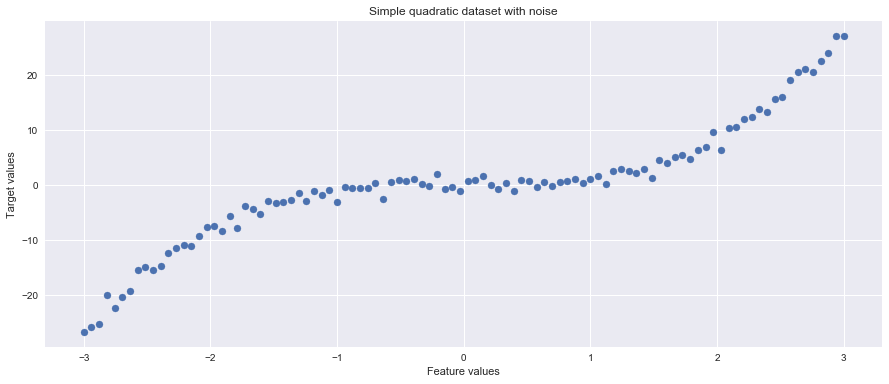

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')
np.random.seed(124)

X = np.linspace(-3, 3, 100)
y = X ** 3 + np.random.randn(100)

plt.figure(figsize=(15,6))
plt.scatter(X, y)
plt.title("Simple quadratic dataset with noise")
plt.xlabel("Feature values")
plt.ylabel("Target values")

In [12]:
X = X[:, np.newaxis]

# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (75, 1)
Shape y_train: (75,)
Shape X_test: (25, 1)
Shape y_test: (25,)


In [13]:
# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0, max_depth=3)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [14]:
y_pred = regressor.predict(X_test)


In [15]:
from sklearn.metrics import mean_squared_error as mse
mse(y_test, y_pred)

5.165993713178738

In [16]:
from sklearn.metrics import r2_score

r2_score(y_test,y_pred)


0.9620185253771402

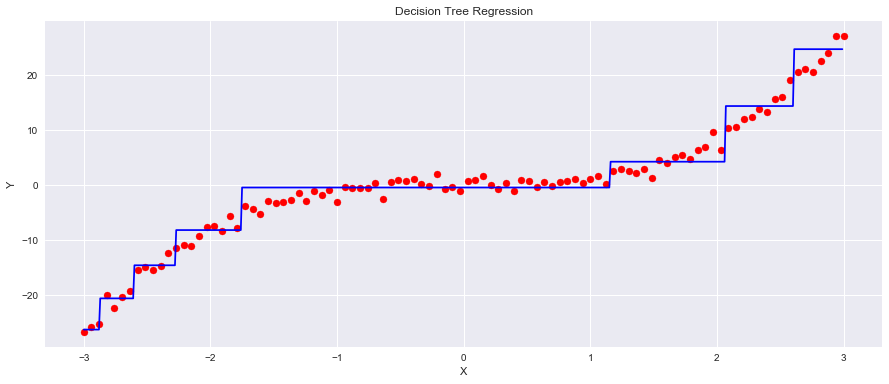

In [17]:
# Visualising the Decision Tree Regression results (higher resolution)
X_grid = np.arange(min(X), max(X), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.figure(figsize=(15,6))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
plt.title('Decision Tree Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

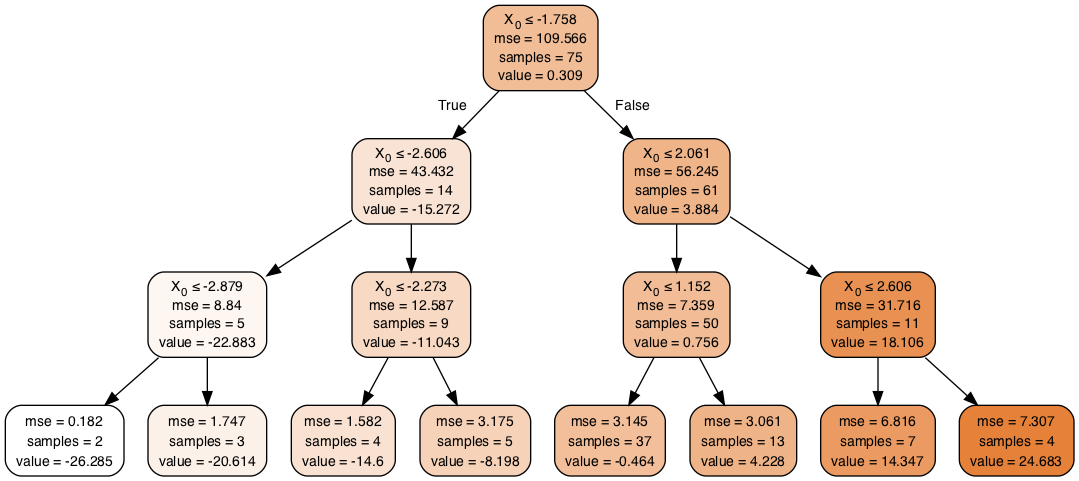

In [18]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(regressor, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Caveats

Without regularization, decision trees are likely to overfit the training examples. This can be prevented using techniques like *pruning* or by providing a maximum allowed tree depth and/or a minimum number of samples required to split a node further.